# GAN LAB Assignment 3 submission by Aditi Dhavale, 22070126006, AIML-A1

https://github.com/Aditi-Dhavale/DCGAN_GANLAB3/tree/main

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import kagglehub

In [ ]:
# Ensure GPU is used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.33G/1.33G [00:09<00:00, 144MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2"

In [ ]:
# Hyperparameters
batch_size = 128    # Number of images per batch
image_size = 64     # Image resolution (resize to 64x64)
nz = 100            # Size of the latent vector (random noise input to Generator)
ngf = 64            # Number of feature maps in Generator
ndf = 64            # Number of feature maps in Discriminator
num_epochs = 5      # Number of training epochs
lr = 0.0002         # Learning rate
beta1 = 0.5         # Beta1 hyperparameter for Adam optimizer

In [ ]:
# Data transformation pipeline (resizing, cropping, normalization)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values between [-1, 1]
])

# Load dataset from Kaggle path
dataset = dsets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# ----------------- Define Generator -----------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),  # Upsample from (nz, 1, 1) → (ngf*8, 4, 4)
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),  # (ngf*8, 4, 4) → (ngf*4, 8, 8)
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # (ngf*4, 8, 8) → (ngf*2, 16, 16)
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),  # (ngf*2, 16, 16) → (ngf, 32, 32)
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),  # (ngf, 32, 32) → (3, 64, 64)
            nn.Tanh()  # Output pixel values between [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# ----------------- Define Discriminator -----------------
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),  # Downsample (3, 64, 64) → (ndf, 32, 32)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # (ndf, 32, 32) → (ndf*2, 16, 16)
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # (ndf*2, 16, 16) → (ndf*4, 8, 8)
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # (ndf*4, 8, 8) → (ndf*8, 4, 4)
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),  # (ndf*8, 4, 4) → (1, 1, 1)
            nn.Sigmoid()  # Output probability
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)

In [ ]:
# Initialize models
netG = Generator().to(device)
netD = Discriminator().to(device)

# Define loss function (Binary Cross Entropy)
criterion = nn.BCELoss().to(device)

# Define optimizers for both Generator and Discriminator
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training
print("Starting Training...")
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        netD.zero_grad()
        labels_real = torch.ones(batch_size, 1, device=device)
        output_real = netD(real_images)
        lossD_real = criterion(output_real, labels_real)

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        labels_fake = torch.zeros(batch_size, 1, device=device)
        output_fake = netD(fake_images.detach())
        lossD_fake = criterion(output_fake, labels_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        labels_gen = torch.ones(batch_size, 1, device=device)
        output_gen = netD(fake_images)
        lossG = criterion(output_gen, labels_gen)
        lossG.backward()
        optimizerG.step()

        # Print loss every 100 batches
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(dataloader)} \n Loss D: {lossD.item()}, Loss G: {lossG.item()}")

    # Save sample images
    vutils.save_image(fake_images, f"generated_epoch_{epoch+1}.png", normalize=True)

print("Training Completed!")


Starting Training...
Epoch [1/5] Batch 0/1583 
 Loss D: 1.4813411235809326, Loss G: 2.4717354774475098
Epoch [1/5] Batch 100/1583 
 Loss D: 0.12033853679895401, Loss G: 5.061392307281494
Epoch [1/5] Batch 200/1583 
 Loss D: 1.291334867477417, Loss G: 3.227886199951172
Epoch [1/5] Batch 300/1583 
 Loss D: 0.5551643371582031, Loss G: 3.05772066116333
Epoch [1/5] Batch 400/1583 
 Loss D: 0.9040241241455078, Loss G: 1.729490041732788
Epoch [1/5] Batch 500/1583 
 Loss D: 0.6200769543647766, Loss G: 2.6505303382873535
Epoch [1/5] Batch 600/1583 
 Loss D: 0.7984551191329956, Loss G: 4.782276153564453
Epoch [1/5] Batch 700/1583 
 Loss D: 0.5535266995429993, Loss G: 4.833754539489746
Epoch [1/5] Batch 800/1583 
 Loss D: 0.6659448146820068, Loss G: 2.7013120651245117
Epoch [1/5] Batch 900/1583 
 Loss D: 0.6846016645431519, Loss G: 1.9111855030059814
Epoch [1/5] Batch 1000/1583 
 Loss D: 0.8220701217651367, Loss G: 5.8738017082214355
Epoch [1/5] Batch 1100/1583 
 Loss D: 1.130627155303955, Loss G

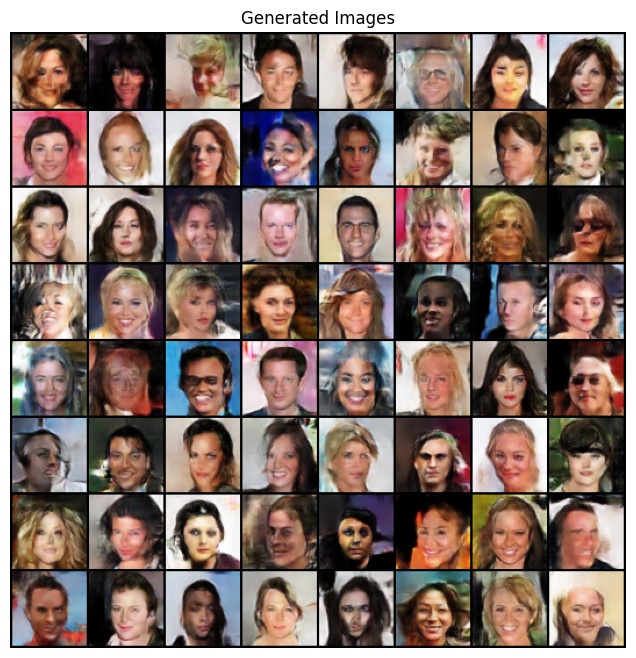

In [ ]:
import torchvision.utils as vutils
import numpy as np

# Define a fixed noise vector for consistent image generation
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Generate images using fixed_noise
with torch.no_grad():
    fake_images = netG(fixed_noise).detach().cpu()

# Convert to grid format
img_grid = vutils.make_grid(fake_images, padding=2, normalize=True)

# Convert from PyTorch tensor to NumPy
np_img = img_grid.permute(1, 2, 0).numpy()

# Plot the generated images
plt.figure(figsize=(8, 8))
plt.imshow(np_img)
plt.axis("off")
plt.title("Generated Images")
plt.show()